In [2]:
# Exploratory Data Analysis (EDA) - Povijesni podaci o potrošnji
# =================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# 1. UČITAVANJE I OSNOVNI PREGLED PODATAKA
# ========================================

print("Trenutni direktorij:", os.getcwd())
print("Sadržaj data/ direktorija:", os.listdir("../data"))

# Load & clean podatke
df = pd.read_csv(
    '../data/historical_consumption.csv',
    skipinitialspace=True,
    parse_dates=['Datum'],
    dayfirst=True
).rename(columns={'potrosnja':'Potrošnja'})

# Set datetime index
df.set_index('Datum', inplace=True)
df.index = pd.to_datetime(df.index)

print(f"\n📊 OSNOVNE INFORMACIJE O PODACIMA:")
print(f"Vremenski raspon: {df.index.min()} do {df.index.max()}")
print(f"Broj dana: {len(df)}")
print(f"Frekvencija: {df.index.freq if df.index.freq else 'Nepoznato (pretpostavljamo dnevno)'}")

display(df.head(10))

Trenutni direktorij: c:\Users\j\Desktop\projects\consumption-forecast\notebooks
Sadržaj data/ direktorija: ['historical_consumption.csv']

📊 OSNOVNE INFORMACIJE O PODACIMA:
Vremenski raspon: 2023-01-01 00:00:00 do 2023-01-31 00:00:00
Broj dana: 31
Frekvencija: Nepoznato (pretpostavljamo dnevno)


,Potrošnja
Datum,
2023-01-01,150
2023-01-02,200
2023-01-03,10
2023-01-04,300
2023-01-05,600
2023-01-06,20
2023-01-07,0
2023-01-08,275
2023-01-09,220


In [4]:
# 2. STATISTIČKA ANALIZA
# ======================

print("📈 DESKRIPTIVNA STATISTIKA:")
display(df['Potrošnja'].describe())

print(f"\n🔍 KVALITETA PODATAKA:")
print(f"Nedostaju vrijednosti: {df['Potrošnja'].isna().sum()}")
print(f"Nulte vrijednosti: {(df['Potrošnja'] == 0).sum()}")
print(f"Negativne vrijednosti: {(df['Potrošnja'] < 0).sum()}")

# Coefficient of Variation
cv = df['Potrošnja'].std() / df['Potrošnja'].mean()
print(f"Koeficijent varijacije: {cv:.2f} ({'Visoka varijabilnost' if cv > 0.5 else 'Umjerena varijabilnost'})")

# Outlier detection using IQR method
Q1 = df['Potrošnja'].quantile(0.25)
Q3 = df['Potrošnja'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Potrošnja'] < lower_bound) | (df['Potrošnja'] > upper_bound)]
print(f"\n🎯 OUTLIERI (IQR metoda):")
print(f"Broj outliera: {len(outliers)} od {len(df)} ({len(outliers)/len(df)*100:.1f}%)")
if len(outliers) > 0:
    print("Outlier vrijednosti:")
    display(outliers)

📈 DESKRIPTIVNA STATISTIKA:


count      31.000000
mean      391.741935
std       452.540088
min         0.000000
25%       117.000000
50%       200.000000
75%       642.500000
max      2000.000000
Name: Potrošnja, dtype: float64


🔍 KVALITETA PODATAKA:
Nedostaju vrijednosti: 0
Nulte vrijednosti: 1
Negativne vrijednosti: 0
Koeficijent varijacije: 1.16 (Visoka varijabilnost)

🎯 OUTLIERI (IQR metoda):
Broj outliera: 1 od 31 (3.2%)
Outlier vrijednosti:


,Potrošnja
Datum,
2023-01-15,2000


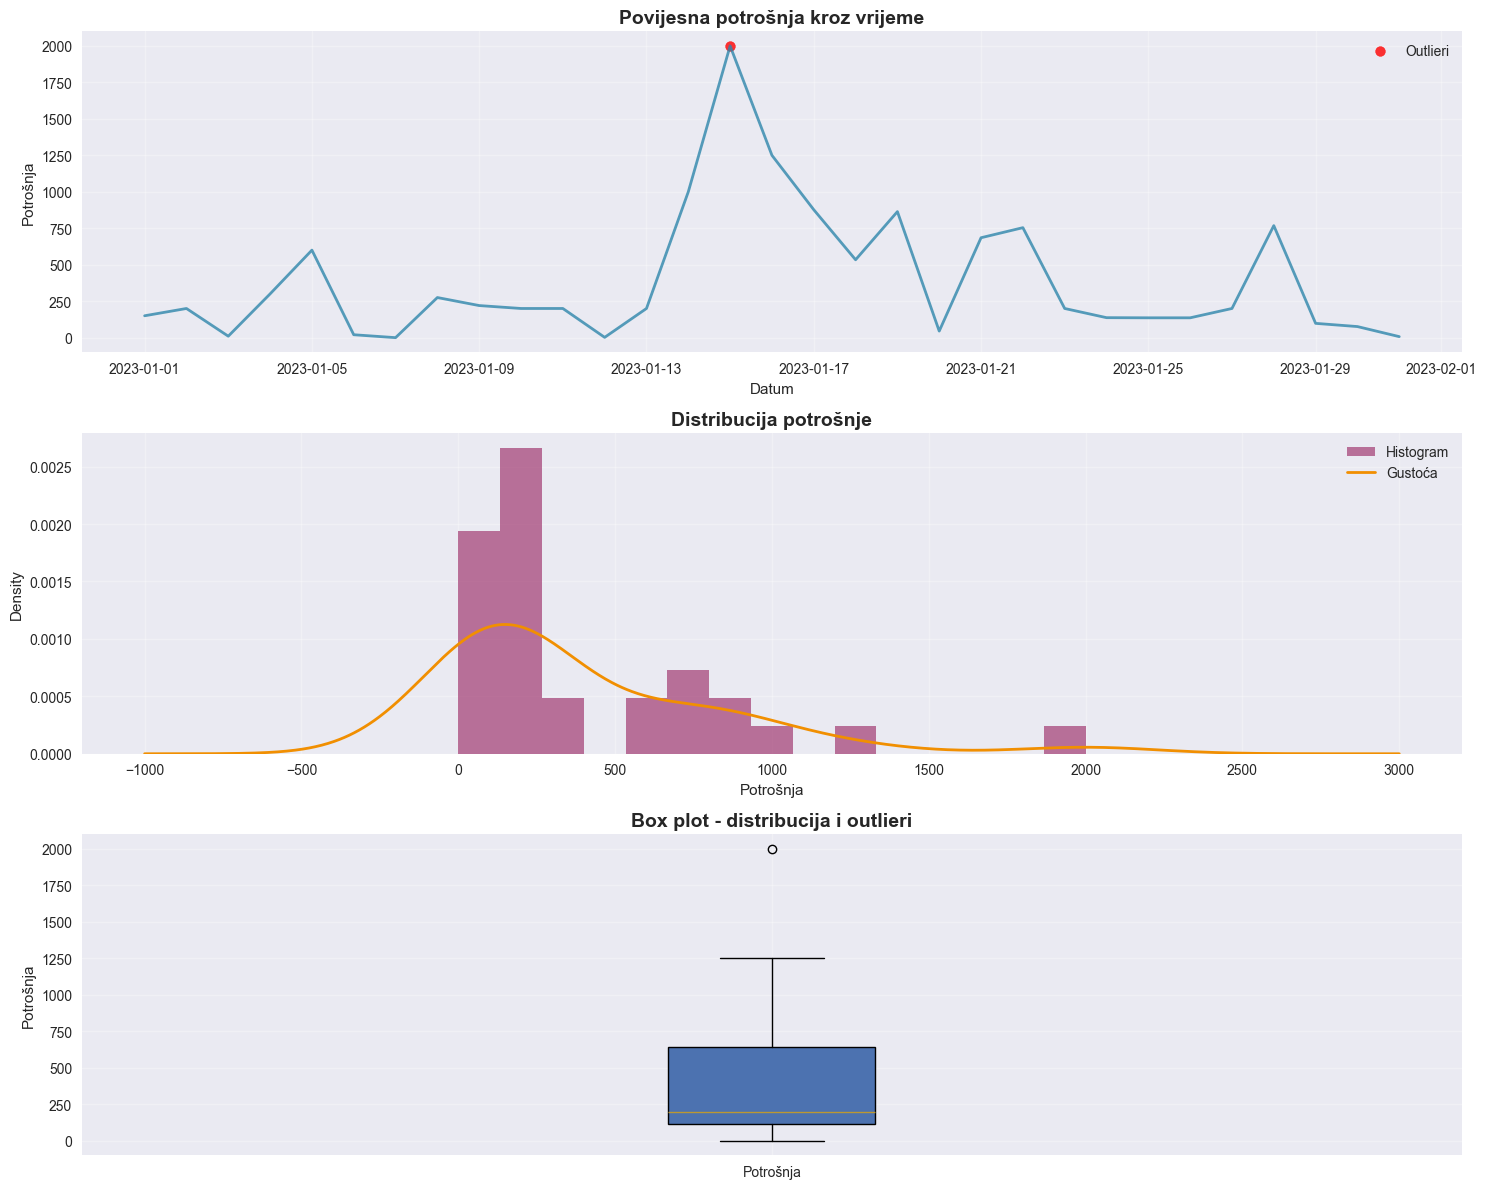

In [5]:
# 3. VIZUALIZACIJA VREMENSKIH SERIJA
# ===================================

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Time series plot
axes[0].plot(df.index, df['Potrošnja'], linewidth=2, alpha=0.8, color='#2E86AB')
axes[0].set_title('Povijesna potrošnja kroz vrijeme', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Datum')
axes[0].set_ylabel('Potrošnja')
axes[0].grid(True, alpha=0.3)

# Mark outliers
if len(outliers) > 0:
    axes[0].scatter(outliers.index, outliers['Potrošnja'], 
                   color='red', s=50, alpha=0.8, label='Outlieri')
    axes[0].legend()

# Distribution (histogram + density)
axes[1].hist(df['Potrošnja'], bins=15, alpha=0.7, color='#A23B72', density=True, label='Histogram')
axes[1].set_title('Distribucija potrošnje', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Potrošnja')
axes[1].set_ylabel('Gustoća')

# Add density curve
df['Potrošnja'].plot.density(ax=axes[1], color='#F18F01', linewidth=2, label='Gustoća')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Box plot
box_data = [df['Potrošnja'].values]
axes[2].boxplot(box_data, labels=['Potrošnja'], patch_artist=True)
axes[2].set_title('Box plot - distribucija i outlieri', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Potrošnja')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📅 ANALIZA VREMENSKIH OBRAZACA:

Prosjećna potrošnja po danima u tjednu:


,mean,std,count
Ponedjeljak,389.20,484.585596,5
Utorak,246.20,362.275724,5
Srijeda,292.50,174.572812,4
Četvrtak,400.50,401.412091,4
Petak,116.25,97.243252,4
Subota,613.25,430.018120,4
Nedjelja,655.40,795.062765,5


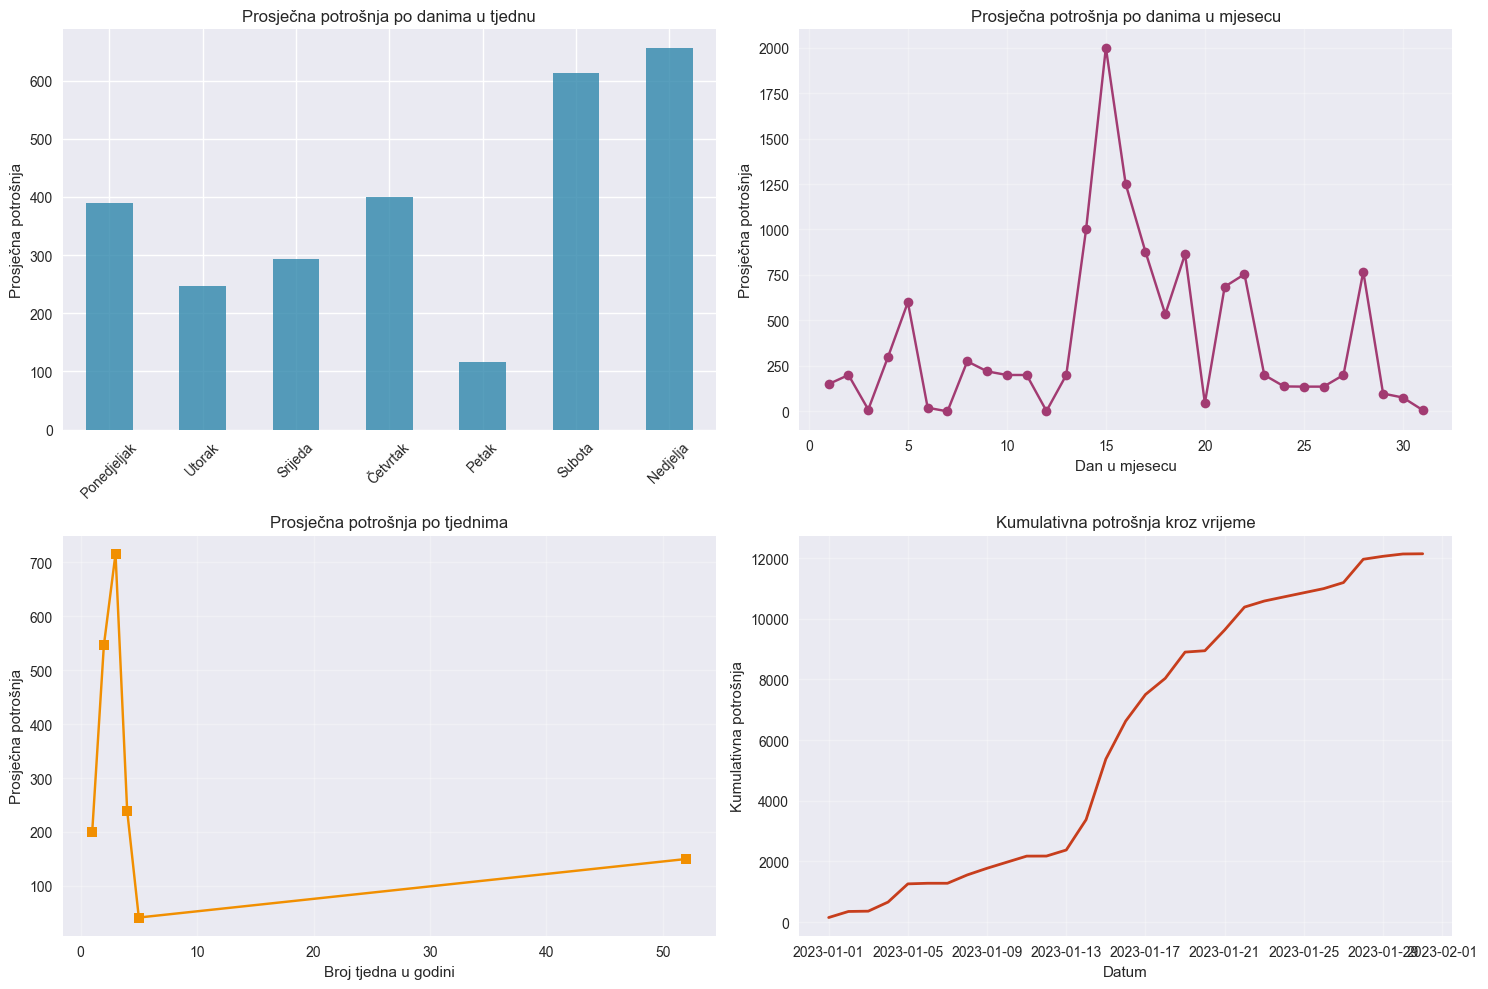

In [6]:
# 4. ANALIZA SEZONALNOSTI I TRENDOVA
# ==================================

# Add temporal features
df_temporal = df.copy()
df_temporal['dan_u_tjednu'] = df_temporal.index.day_of_week
df_temporal['dan_u_mjesecu'] = df_temporal.index.day
df_temporal['broj_tjedna'] = df_temporal.index.isocalendar().week

print("📅 ANALIZA VREMENSKIH OBRAZACA:")

# Day of week analysis
print("\nProsjećna potrošnja po danima u tjednu:")
dow_stats = df_temporal.groupby('dan_u_tjednu')['Potrošnja'].agg(['mean', 'std', 'count'])
dow_stats.index = ['Ponedjeljak', 'Utorak', 'Srijeda', 'Četvrtak', 'Petak', 'Subota', 'Nedjelja']
display(dow_stats)

# Visualize patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Day of week pattern
dow_stats['mean'].plot(kind='bar', ax=axes[0,0], color='#2E86AB', alpha=0.8)
axes[0,0].set_title('Prosječna potrošnja po danima u tjednu')
axes[0,0].set_ylabel('Prosječna potrošnja')
axes[0,0].tick_params(axis='x', rotation=45)

# Day of month pattern
dom_stats = df_temporal.groupby('dan_u_mjesecu')['Potrošnja'].mean()
dom_stats.plot(ax=axes[0,1], color='#A23B72', marker='o')
axes[0,1].set_title('Prosječna potrošnja po danima u mjesecu')
axes[0,1].set_xlabel('Dan u mjesecu')
axes[0,1].set_ylabel('Prosječna potrošnja')
axes[0,1].grid(True, alpha=0.3)

# Weekly pattern
week_stats = df_temporal.groupby('broj_tjedna')['Potrošnja'].mean()
week_stats.plot(ax=axes[1,0], color='#F18F01', marker='s')
axes[1,0].set_title('Prosječna potrošnja po tjednima')
axes[1,0].set_xlabel('Broj tjedna u godini')
axes[1,0].set_ylabel('Prosječna potrošnja')
axes[1,0].grid(True, alpha=0.3)

# Cumulative consumption
df_temporal['kumulativna_potrošnja'] = df_temporal['Potrošnja'].cumsum()
axes[1,1].plot(df_temporal.index, df_temporal['kumulativna_potrošnja'], 
               color='#C73E1D', linewidth=2)
axes[1,1].set_title('Kumulativna potrošnja kroz vrijeme')
axes[1,1].set_xlabel('Datum')
axes[1,1].set_ylabel('Kumulativna potrošnja')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 TESTIRANJE STACIONARNOSTI (Augmented Dickey-Fuller test):

Originalna serija:
ADF statistika: -2.808814
p-vrijednost: 0.057026
Kritične vrijednosti:
	1%: -3.670
	5%: -2.964
	10%: -2.621
❌ Serija NIJE stacionarna (p >= 0.05)


Prva razlika (differenced):
ADF statistika: -5.998954
p-vrijednost: 0.000000
Kritične vrijednosti:
	1%: -3.679
	5%: -2.968
	10%: -2.623
✅ Serija je STACIONARNA (p < 0.05)


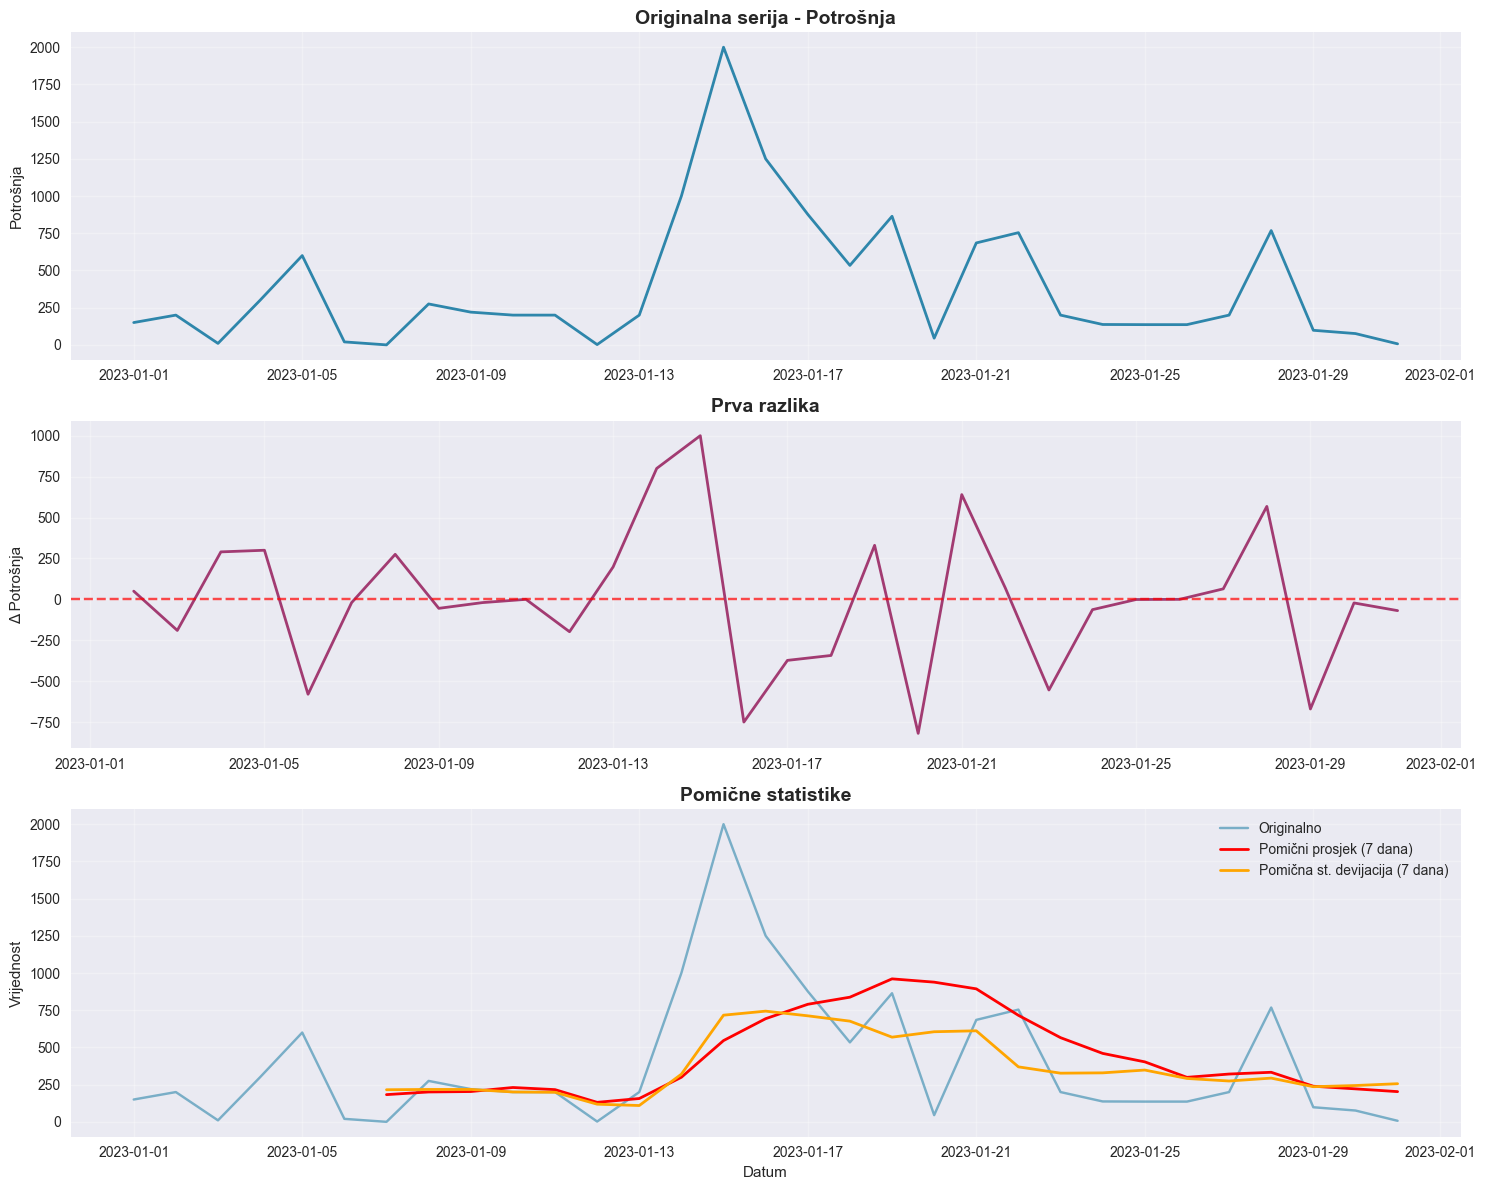

In [7]:
# 5. ANALIZA STACIONARNOSTI - KLJUČNO ZA ARIMA MODELE
# ====================================================

print("📊 TESTIRANJE STACIONARNOSTI (Augmented Dickey-Fuller test):")

# Perform ADF test
def adf_test(series, title=""):
    result = adfuller(series.dropna())
    print(f"\n{title}:")
    print(f"ADF statistika: {result[0]:.6f}")
    print(f"p-vrijednost: {result[1]:.6f}")
    print(f"Kritične vrijednosti:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print("✅ Serija je STACIONARNA (p < 0.05)")
    else:
        print("❌ Serija NIJE stacionarna (p >= 0.05)")
    
    return result[1] <= 0.05

# Test original series
is_stationary = adf_test(df['Potrošnja'], "Originalna serija")

# Test first difference if not stationary
if not is_stationary:
    df_diff = df['Potrošnja'].diff().dropna()
    print("\n" + "="*50)
    is_diff_stationary = adf_test(df_diff, "Prva razlika (differenced)")
    
    if not is_diff_stationary:
        df_diff2 = df_diff.diff().dropna()
        print("\n" + "="*50)
        adf_test(df_diff2, "Druga razlika")

# Visual inspection of stationarity
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Original series
axes[0].plot(df.index, df['Potrošnja'], color='#2E86AB', linewidth=2)
axes[0].set_title('Originalna serija - Potrošnja', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Potrošnja')
axes[0].grid(True, alpha=0.3)

# First difference
if 'df_diff' in locals():
    axes[1].plot(df.index[1:], df_diff, color='#A23B72', linewidth=2)
    axes[1].set_title('Prva razlika', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Δ Potrošnja')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Rolling statistics
window = min(7, len(df)//3)  # Adjust window size for small datasets
rolling_mean = df['Potrošnja'].rolling(window=window).mean()
rolling_std = df['Potrošnja'].rolling(window=window).std()

axes[2].plot(df.index, df['Potrošnja'], color='#2E86AB', alpha=0.6, label='Originalno')
axes[2].plot(df.index, rolling_mean, color='red', linewidth=2, label=f'Pomični prosjek ({window} dana)')
axes[2].plot(df.index, rolling_std, color='orange', linewidth=2, label=f'Pomična st. devijacija ({window} dana)')
axes[2].set_title('Pomične statistike', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Datum')
axes[2].set_ylabel('Vrijednost')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📈 ANALIZA AUTOKORELACIJE:
Ova analiza pomaže u određivanju ARIMA parametara (p, d, q)
Analiziramo: Prva razlika


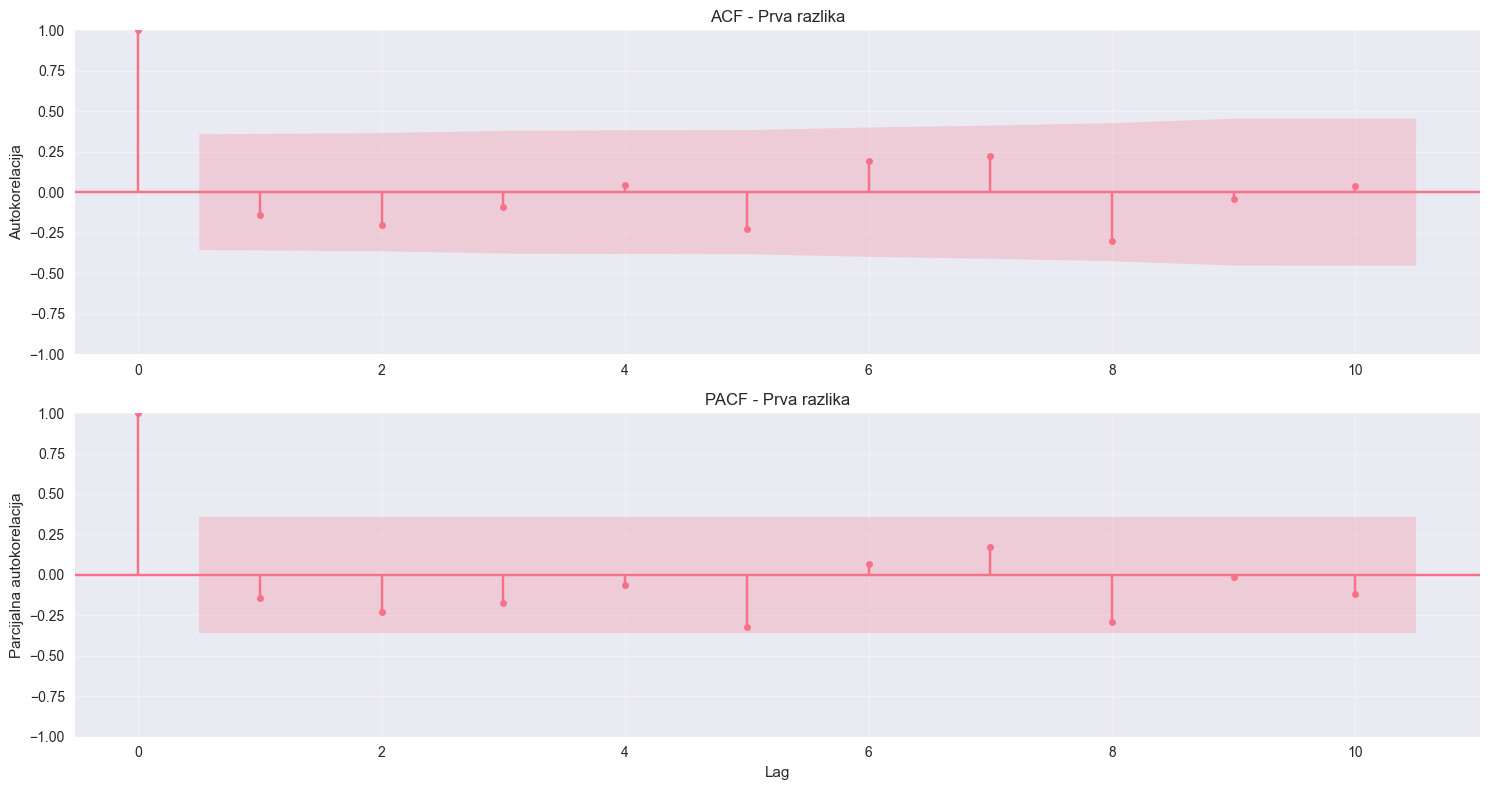


💡 INTERPRETACIJA ZA ARIMA PARAMETRE:
• AR(p): Pogledajte PACF - značajni lagovi određuju 'p'
• MA(q): Pogledajte ACF - značajni lagovi određuju 'q'
• I(d): Broj razlika potreban za stacionarnost određuje 'd'
• Preporučujemo testiranje ARIMA modela s d=1)


In [8]:
# 6. AUTOKORELACIJA I PARCIJALNA AUTOKORELACIJA - ZA ARIMA PARAMETRE
# ====================================================================

print("📈 ANALIZA AUTOKORELACIJE:")
print("Ova analiza pomaže u određivanju ARIMA parametara (p, d, q)")

# Determine series to analyze
series_to_analyze = df['Potrošnja']
series_name = "Originalna serija"

# If series is not stationary, use first difference
if not is_stationary and 'df_diff' in locals():
    series_to_analyze = df_diff
    series_name = "Prva razlika"

print(f"Analiziramo: {series_name}")

# Calculate max lags (limited by sample size)
max_lags = min(10, len(series_to_analyze) // 3)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF plot
plot_acf(series_to_analyze, lags=max_lags, ax=axes[0], title=f'ACF - {series_name}')
axes[0].set_ylabel('Autokorelacija')
axes[0].grid(True, alpha=0.3)

# PACF plot
plot_pacf(series_to_analyze, lags=max_lags, ax=axes[1], title=f'PACF - {series_name}')
axes[1].set_ylabel('Parcijalna autokorelacija')
axes[1].set_xlabel('Lag')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIJA ZA ARIMA PARAMETRE:")
print("• AR(p): Pogledajte PACF - značajni lagovi određuju 'p'")
print("• MA(q): Pogledajte ACF - značajni lagovi određuju 'q'") 
print("• I(d): Broj razlika potreban za stacionarnost određuje 'd'")
print(f"• Preporučujemo testiranje ARIMA modela s d={1 if not is_stationary else 0})")

# 📋 SAŽETAK EDA ANALIZE

## Ključni nalazi:

### 1. **Kvaliteta podataka**
- Vremenski raspon i broj opservacija
- Broj nedostajućih vrijednosti i outliera
- Varijabilnost podataka

### 2. **Vremenska struktura**
- Sezonalnost (dnevna, tjedna)
- Trendovi u podacima
- Ciklični obrasci

### 3. **Stacionarnost**
- Rezultat ADF testa
- Potreba za diferenciranjem
- Preporučen parametar 'd' za ARIMA

### 4. **ARIMA parametri**
- Analiza ACF/PACF za p, q parametre
- Preporučene kombinacije za testiranje

## Sljedeći korak:
➡️ **02_Preparation.ipynb** - Priprema podataka za modeliranje